- case5: case4 SMOTE & standard scaler

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [146]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import os
import warnings

warnings.filterwarnings("ignore")

In [147]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [148]:
n_splits = 3
random_seed = 2025

# Data

In [149]:
train_sleep_file_path = "../data/train/raw/train_sleep.csv"
train_activity_file_path = "../data/train/raw/train_activity.csv"
train_label_file_path = "../data/train/label/sleep/training_label.csv"

test_sleep_file_path = "../data/validation/raw/val_sleep.csv"
test_activity_file_path = "../data/validation/raw/val_activity.csv"
test_label_file_path = "../data/validation/label/sleep/val_label.csv"

train_derived_file_path = "../data/derived_var/train_add.csv"
test_derived_file_path = "../data/derived_var/test_add.csv"

train2_derived_file_path = "../data/derived_var/bong_train.csv"
test2_derived_file_path = "../data/derived_var/bong_test.csv"

train3_derived_file_path = "../data/derived_var/sleep_train_add.csv"
test3_derived_file_path = "../data/derived_var/sleep_test_add.csv"

In [150]:
train_label = pd.read_csv(train_label_file_path)
train_sleep = pd.read_csv(train_sleep_file_path)
train_activity = pd.read_csv(train_activity_file_path)

test_label = pd.read_csv(test_label_file_path)
test_sleep = pd.read_csv(test_sleep_file_path)
test_activity = pd.read_csv(test_activity_file_path)

train_derived = pd.read_csv(train_derived_file_path)
test_derived = pd.read_csv(test_derived_file_path)

train_derived2 = pd.read_csv(train2_derived_file_path)
test_derived2 = pd.read_csv(test2_derived_file_path)
test_derived2.drop(["Unnamed: 0"], inplace=True, axis=1)

train_derived3 = pd.read_csv(train3_derived_file_path)
test_derived3 = pd.read_csv(test3_derived_file_path)

In [151]:
# train, test email exclusive 확인
common_elements = list(
    set(train_label["SAMPLE_EMAIL"]) & set(test_label["SAMPLE_EMAIL"])
)
len(common_elements)

0

In [152]:
# sleep + label
train = train_sleep.merge(train_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
test = test_sleep.merge(test_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
train.drop(["SAMPLE_EMAIL"], axis=1, inplace=True)
test.drop(["SAMPLE_EMAIL"], axis=1, inplace=True)

# sleep + activity
train = pd.concat([train, train_activity.drop(["EMAIL"], axis=1)], axis=1)
test = pd.concat([test, test_activity.drop(["EMAIL"], axis=1)], axis=1)

In [153]:
train["activity_date"] = pd.to_datetime(train["activity_day_start"]).dt.date.astype(str)
test["activity_date"] = pd.to_datetime(test["activity_day_start"]).dt.date.astype(str)

In [154]:
train = train.merge(train_derived, on=["EMAIL", "activity_date"], how="inner")
test = test.merge(test_derived, on=["EMAIL", "activity_date"], how="inner")

In [155]:
train = train.merge(train_derived3, on=["EMAIL", "activity_date"], how="inner")
test = test.merge(test_derived3, on=["EMAIL", "activity_date"], how="inner")

In [156]:
train = pd.concat(
    [train, train_derived2.drop(["EMAIL", "activity_day_start"], axis=1)], axis=1
)
test = pd.concat(
    [test, test_derived2.drop(["EMAIL", "activity_day_start"], axis=1)], axis=1
)

In [157]:
for col in train.columns:
    if "_x" in col:
        train.drop([col], axis=1, inplace=True)
        train.rename(
            columns={col.replace("_x", "_y"): col.replace("_x", "")}, inplace=True
        )
    if "avg_" in col:
        train.drop([col], axis=1, inplace=True)
    if "std_" in col:
        train.drop([col], axis=1, inplace=True)

for col in test.columns:
    if "_x" in col:
        test.drop([col], axis=1, inplace=True)
        test.rename(
            columns={col.replace("_x", "_y"): col.replace("_x", "")}, inplace=True
        )
    if "avg_" in col:
        test.drop([col], axis=1, inplace=True)
    if "std_" in col:
        test.drop([col], axis=1, inplace=True)

In [158]:
label_encoder = {"CN": 0, "MCI": 1, "Dem": 2}

In [159]:
train["label"] = train["DIAG_NM"].map(label_encoder)
test["label"] = test["DIAG_NM"].map(label_encoder)
train.drop(["DIAG_NM"], axis=1, inplace=True)
test.drop(["DIAG_NM"], axis=1, inplace=True)

# train + test

In [160]:
all_data = pd.concat([train, test], axis=0)
all_data = all_data.drop(["label"], axis=1)  # 타겟값 제거

# feature selection

In [161]:
drop_features = [
    "sleep_period_id",
    "sleep_is_longest",
    "sleep_temperature_delta",
    "sleep_temperature_deviation",
    "sleep_midpoint_time",
    "activity_inactivity_alerts",
    "sleep_total",
    "sleep_midpoint_at_delta_sin_cumsum",
    "sleep_midpoint_at_delta_cos_cumsum",
    "sleep_startpoint_at_delta_sin_cumsum",
    "sleep_startpoint_at_delta_cos_cumsum",
    "sleep_midpoint_at_delta_sin",
    "sleep_midpoint_at_delta_cos",
    "sleep_startpoint_at_delta_sin",
    "sleep_startpoint_at_delta_cos",
    # low importance
    "deep_ratio_5h_lag2",
    "deep_ratio_5h_3d_avg",
    "deep_ratio_5h_30d_avg",
    "deep_ratio_5h",
    "awake_ratio_5h_3d_avg",
    "awake_ratio_5h",
    "hr_pattern_5",
    "sleep_end_weekday",
    "hr_pattern_0",
    "activity_inactive_lag3",
    "morning_ratio",
    "activity_average_met_lag2",
    "activity_inactive_lag2",
    "morning_ratio_3d_avg",
    "evening_ratio_3d_avg",
    "evening_ratio_lag2",
    "total_met_3d_avg",
    "rmssd_min_0_90",
    "rmssd_rmsd_0_90",
    "hr_entropy_0_90",
    "count_0_90_deep",
    "rmssd_entropy_0_90",
    "rmssd_mad_0_90",
    "rmssd_iqr_0_90",
    "met_min_10_14",
    "morning_ratio_lag3",
    "sleep_score_latency",
    "met_mad_10_14",
    "activity_inactive",
    "activity_average_met_lag3",
    "total_met",
    "activity_cal_active",
    "daytime",
    "activity_medium",
    "total_met_lag2",
    "activity_average_met_3d_avg",
    "activity_average_met",
    "activity_daily_movement",
    "sleep_score_total",
    "bedtime_hour",
    "activity_score_recovery_time",
    "abnormal_wake_time",
    "activity_score_stay_active",
    "morning_ratio_lag2",
    "evening_ratio_7d_avg",
    "evening_ratio_lag3",
    "evening_ratio",
    "met_rmsd_10_14",
    "total_met_lag3",
    "morning_ratio_7d_avg",
    "sleep_awake",
]

all_data = all_data[all_data.columns.difference(drop_features)]

all_data = all_data.select_dtypes(include=[int, float])  # 숫자형 데이터만
selected_features = all_data.columns

selected_features.values, len(selected_features)  # original = 51

(array(['abnormal_wake_time', 'activity_average_met',
        'activity_average_met_30d_avg', 'activity_average_met_3d_avg',
        'activity_average_met_7d_avg', 'activity_average_met_lag2',
        'activity_average_met_lag3', 'activity_cal_active',
        'activity_cal_total', 'activity_daily_movement', 'activity_high',
        'activity_inactive', 'activity_inactive_30d_avg',
        'activity_inactive_3d_avg', 'activity_inactive_7d_avg',
        'activity_inactive_lag2', 'activity_inactive_lag3', 'activity_low',
        'activity_medium', 'activity_met_min_high',
        'activity_met_min_inactive', 'activity_met_min_low',
        'activity_met_min_medium', 'activity_non_wear', 'activity_rest',
        'activity_score', 'activity_score_meet_daily_targets',
        'activity_score_move_every_hour', 'activity_score_recovery_time',
        'activity_score_stay_active', 'activity_score_training_frequency',
        'activity_score_training_volume', 'activity_steps',
        'activity

# 데이터 다운캐스팅

In [162]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2  # 1MB = 1024**2 Byte
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object":
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast="integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast="float")
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print("{:.1f}% 압축됨".format(100 * (start_mem - end_mem) / start_mem))

    return df


all_data = downcast(all_data)

65.7% 압축됨


# 데이터 나누기

In [163]:
merged_df = pd.concat([all_data, train[["EMAIL", "label"]]], axis=1)

X_test = merged_df.loc[test.index, selected_features]
y_test = merged_df.loc[test.index, "label"]

merged_df = merged_df.loc[: train.index[-1]]

In [164]:
merged_df.shape, X_test.shape, y_test.shape

((9704, 104), (4956, 102), (4956,))

# DIAG_NM(label) 비율

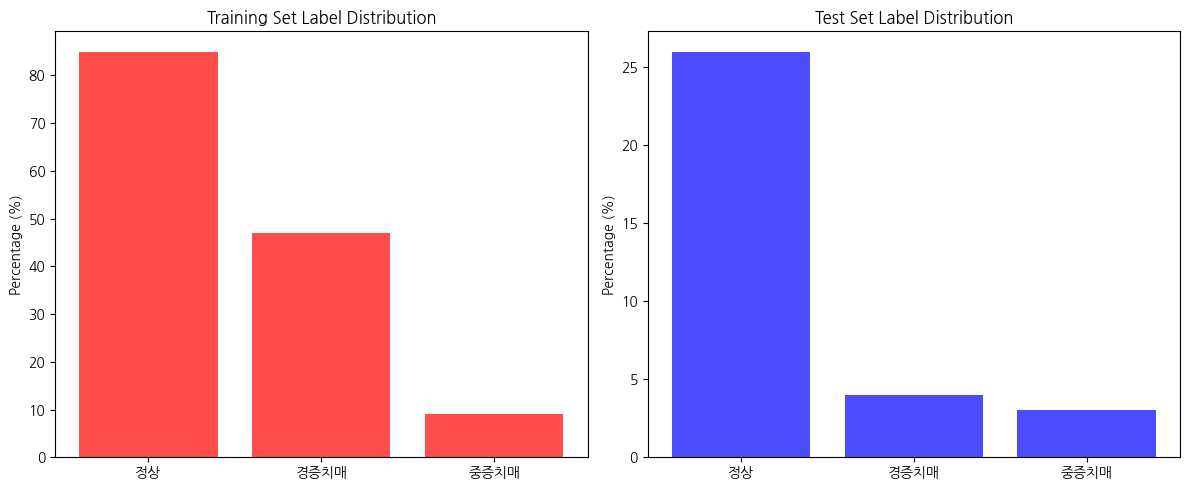

In [165]:
import matplotlib.pyplot as plt

class_distribution_train = train_label["DIAG_NM"].value_counts()
class_distribution_test = test_label["DIAG_NM"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(
    class_distribution_train.index,
    class_distribution_train.values,
    color="red",
    alpha=0.7,
)
axes[0].set_xlabel(None)
axes[0].set_ylabel("Percentage (%)")
axes[0].set_title("Training Set Label Distribution")
axes[0].set_xticks([0, 1, 2], ["정상", "경증치매", "중증치매"])

axes[1].bar(
    class_distribution_test.index,
    class_distribution_test.values,
    color="blue",
    alpha=0.7,
)
axes[1].set_xlabel(None)
axes[1].set_ylabel("Percentage (%)")
axes[1].set_title("Test Set Label Distribution")
axes[1].set_xticks([0, 1, 2], ["정상", "경증치매", "중증치매"])

plt.tight_layout()
plt.show()

# 모델 학습 및 성능 검증

In [166]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# 모델 학습 및 평가
models = {
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=random_seed,
    ),
    "Random Forest": RandomForestClassifier(random_state=random_seed, n_jobs=-1),
}

In [167]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

# StandardScaler
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()


def evaluate_model(name, model, merged_df, n_splits=n_splits):
    acc_scores = []
    f1_scores = []
    class_report_list = []
    folds = []

    # unique EMAIL, label 쌍 추출
    unique_patient_labels = merged_df[["EMAIL", "label"]].drop_duplicates()

    # StratifiedKFold를 사용하여 라벨 비율을 유지하면서 Fold를 생성
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

    for fold_idx, (train_idx, val_idx) in enumerate(
        skf.split(unique_patient_labels["EMAIL"], unique_patient_labels["label"])
    ):
        # 학습/검증 데이터 이메일 리스트 추출
        train_emails = unique_patient_labels.iloc[train_idx]["EMAIL"]
        val_emails = unique_patient_labels.iloc[val_idx]["EMAIL"]

        # 이메일 기준으로 원본 데이터에서 train/validation 데이터 생성
        X_train = merged_df[merged_df["EMAIL"].isin(train_emails)].copy()
        X_val = merged_df[merged_df["EMAIL"].isin(val_emails)].copy()

        y_train = X_train["label"]
        y_val = X_val["label"]
        X_train.drop(["EMAIL", "label"], axis=1, inplace=True)
        X_val.drop(["EMAIL", "label"], axis=1, inplace=True)

        X_train = standard_scaler.fit_transform(X_train)
        X_val = standard_scaler.transform(X_val)

        X_train, y_train = SMOTE(random_state=random_seed).fit_resample(
            X_train, y_train
        )

        # 모델 학습
        model.fit(X_train, y_train)

        # 모델 예측
        y_pred = model.predict(X_val)

        # 평가
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="weighted")  # 불균형 데이터 고려
        acc_scores.append(acc)
        f1_scores.append(f1)

        # Classification Report 저장
        report = classification_report(y_val, y_pred, output_dict=True)
        class_report_list.append(pd.DataFrame(report).T)

        folds.append((X_train, X_val, y_train, y_val))

    # Classification Report 평균
    avg_class_report = pd.concat(class_report_list).groupby(level=0).mean()

    # Accuracy 및 F1-score 평균 출력
    print("#" * 40, f"Model: {name}", "#" * 40)
    print(f"=== Average Classification Report ===")
    print(avg_class_report)
    print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Average F1-score: {np.mean(f1_scores):.4f}")
    print("=" * 60)

    return name, model, folds


models_ = {}
folds_ = {}

# 모델별 평가 실행
for name, model in models.items():
    name_, model_, fold_ = evaluate_model(name, model, merged_df)
    models_[name] = model_
    folds_[name] = fold_

######################################## Model: Gradient Boosting ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.613638  0.675159  0.640764  1926.666667
1              0.410760  0.349368  0.369511  1117.666667
2              0.349228  0.205586  0.222066   190.333333
accuracy       0.533509  0.533509  0.533509     0.533509
macro avg      0.457875  0.410038  0.410780  3234.666667
weighted avg   0.528786  0.533509  0.522071  3234.666667
Average Accuracy: 0.5335
Average F1-score: 0.5221
######################################## Model: Random Forest ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.584971  0.719406  0.643347  1926.666667
1              0.346353  0.230667  0.268047  1117.666667
2              0.501312  0.179713  0.217732   190.333333
accuracy       0.517530  0.517530  0.

# Test dataset 예측 결과

In [168]:
# Test Set 성능 평가
print("\n", "=" * 40, "TEST SET EVALUATION", "=" * 40, "\n")

X_test = standard_scaler.transform(X_test)

for name, model in models_.items():
    print(f"=== Evaluating {name} on Test Set ===")

    # 테스트 데이터 예측
    y_test_pred = model.predict(X_test)

    # 테스트 데이터 평가
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")  # 불균형 고려
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # 결과 출력
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test Classification Report:\n", pd.DataFrame(test_report).T)
    print("=" * 60)


 ======================================== TEST SET EVALUATION ======================================== 

=== Evaluating Gradient Boosting on Test Set ===
Test Accuracy: 0.5734
Test F1-score: 0.5728
Test Classification Report:
               precision    recall  f1-score      support
0              0.598454  0.627799  0.612776  2590.000000
1              0.520172  0.513815  0.516974  1882.000000
2              0.655263  0.514463  0.576389   484.000000
accuracy       0.573446  0.573446  0.573446     0.573446
macro avg      0.591296  0.552026  0.568713  4956.000000
weighted avg   0.574275  0.573446  0.572842  4956.000000
=== Evaluating Random Forest on Test Set ===
Test Accuracy: 0.5829
Test F1-score: 0.5813
Test Classification Report:
               precision    recall  f1-score     support
0              0.597087  0.664865  0.629156  2590.00000
1              0.522624  0.490967  0.506301  1882.00000
2              0.799342  0.502066  0.616751   484.00000
accuracy       0.582930  0.5829

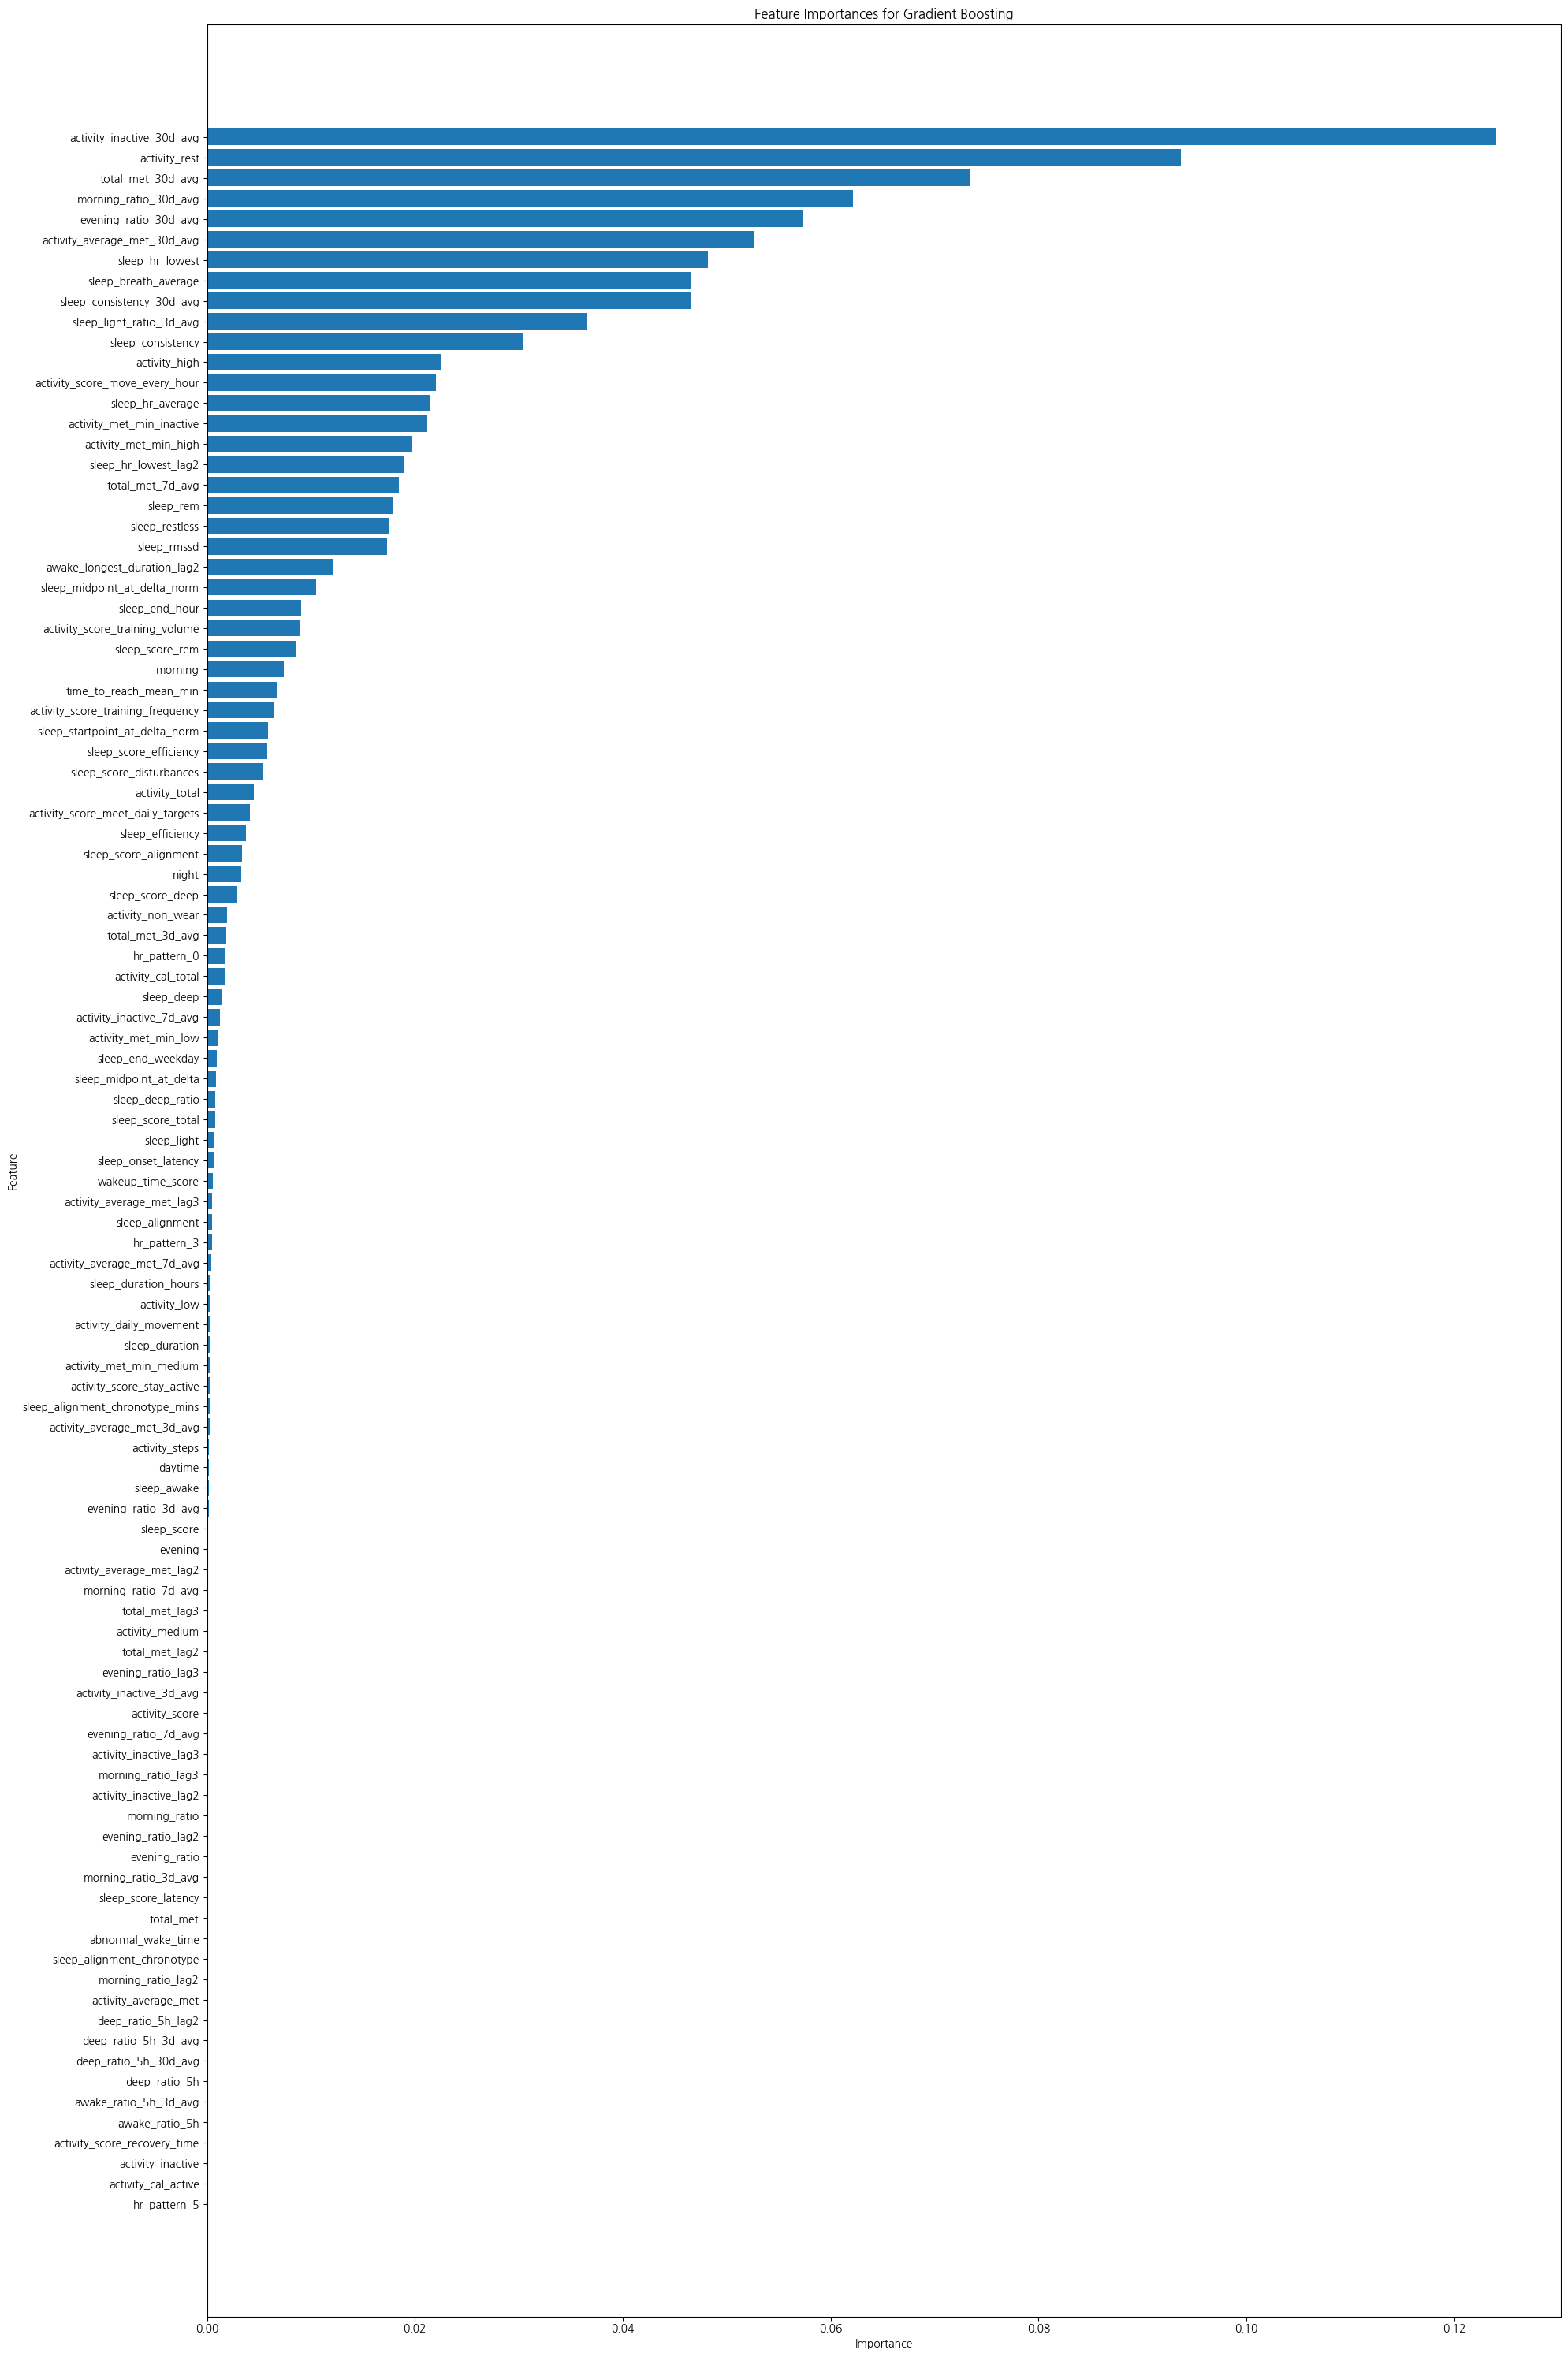

Low importance features for Gradient Boosting:
                           Feature  Importance
72                  sleep_end_hour    0.009035
31  activity_score_training_volume    0.008941
91                 sleep_score_rem    0.008564
52                         morning    0.007402
94          time_to_reach_mean_min    0.006748
..                             ...         ...
35                  awake_ratio_5h    0.000000
28    activity_score_recovery_time    0.000000
11               activity_inactive    0.000000
7              activity_cal_active    0.000000
51                    hr_pattern_5    0.000000

[79 rows x 2 columns]


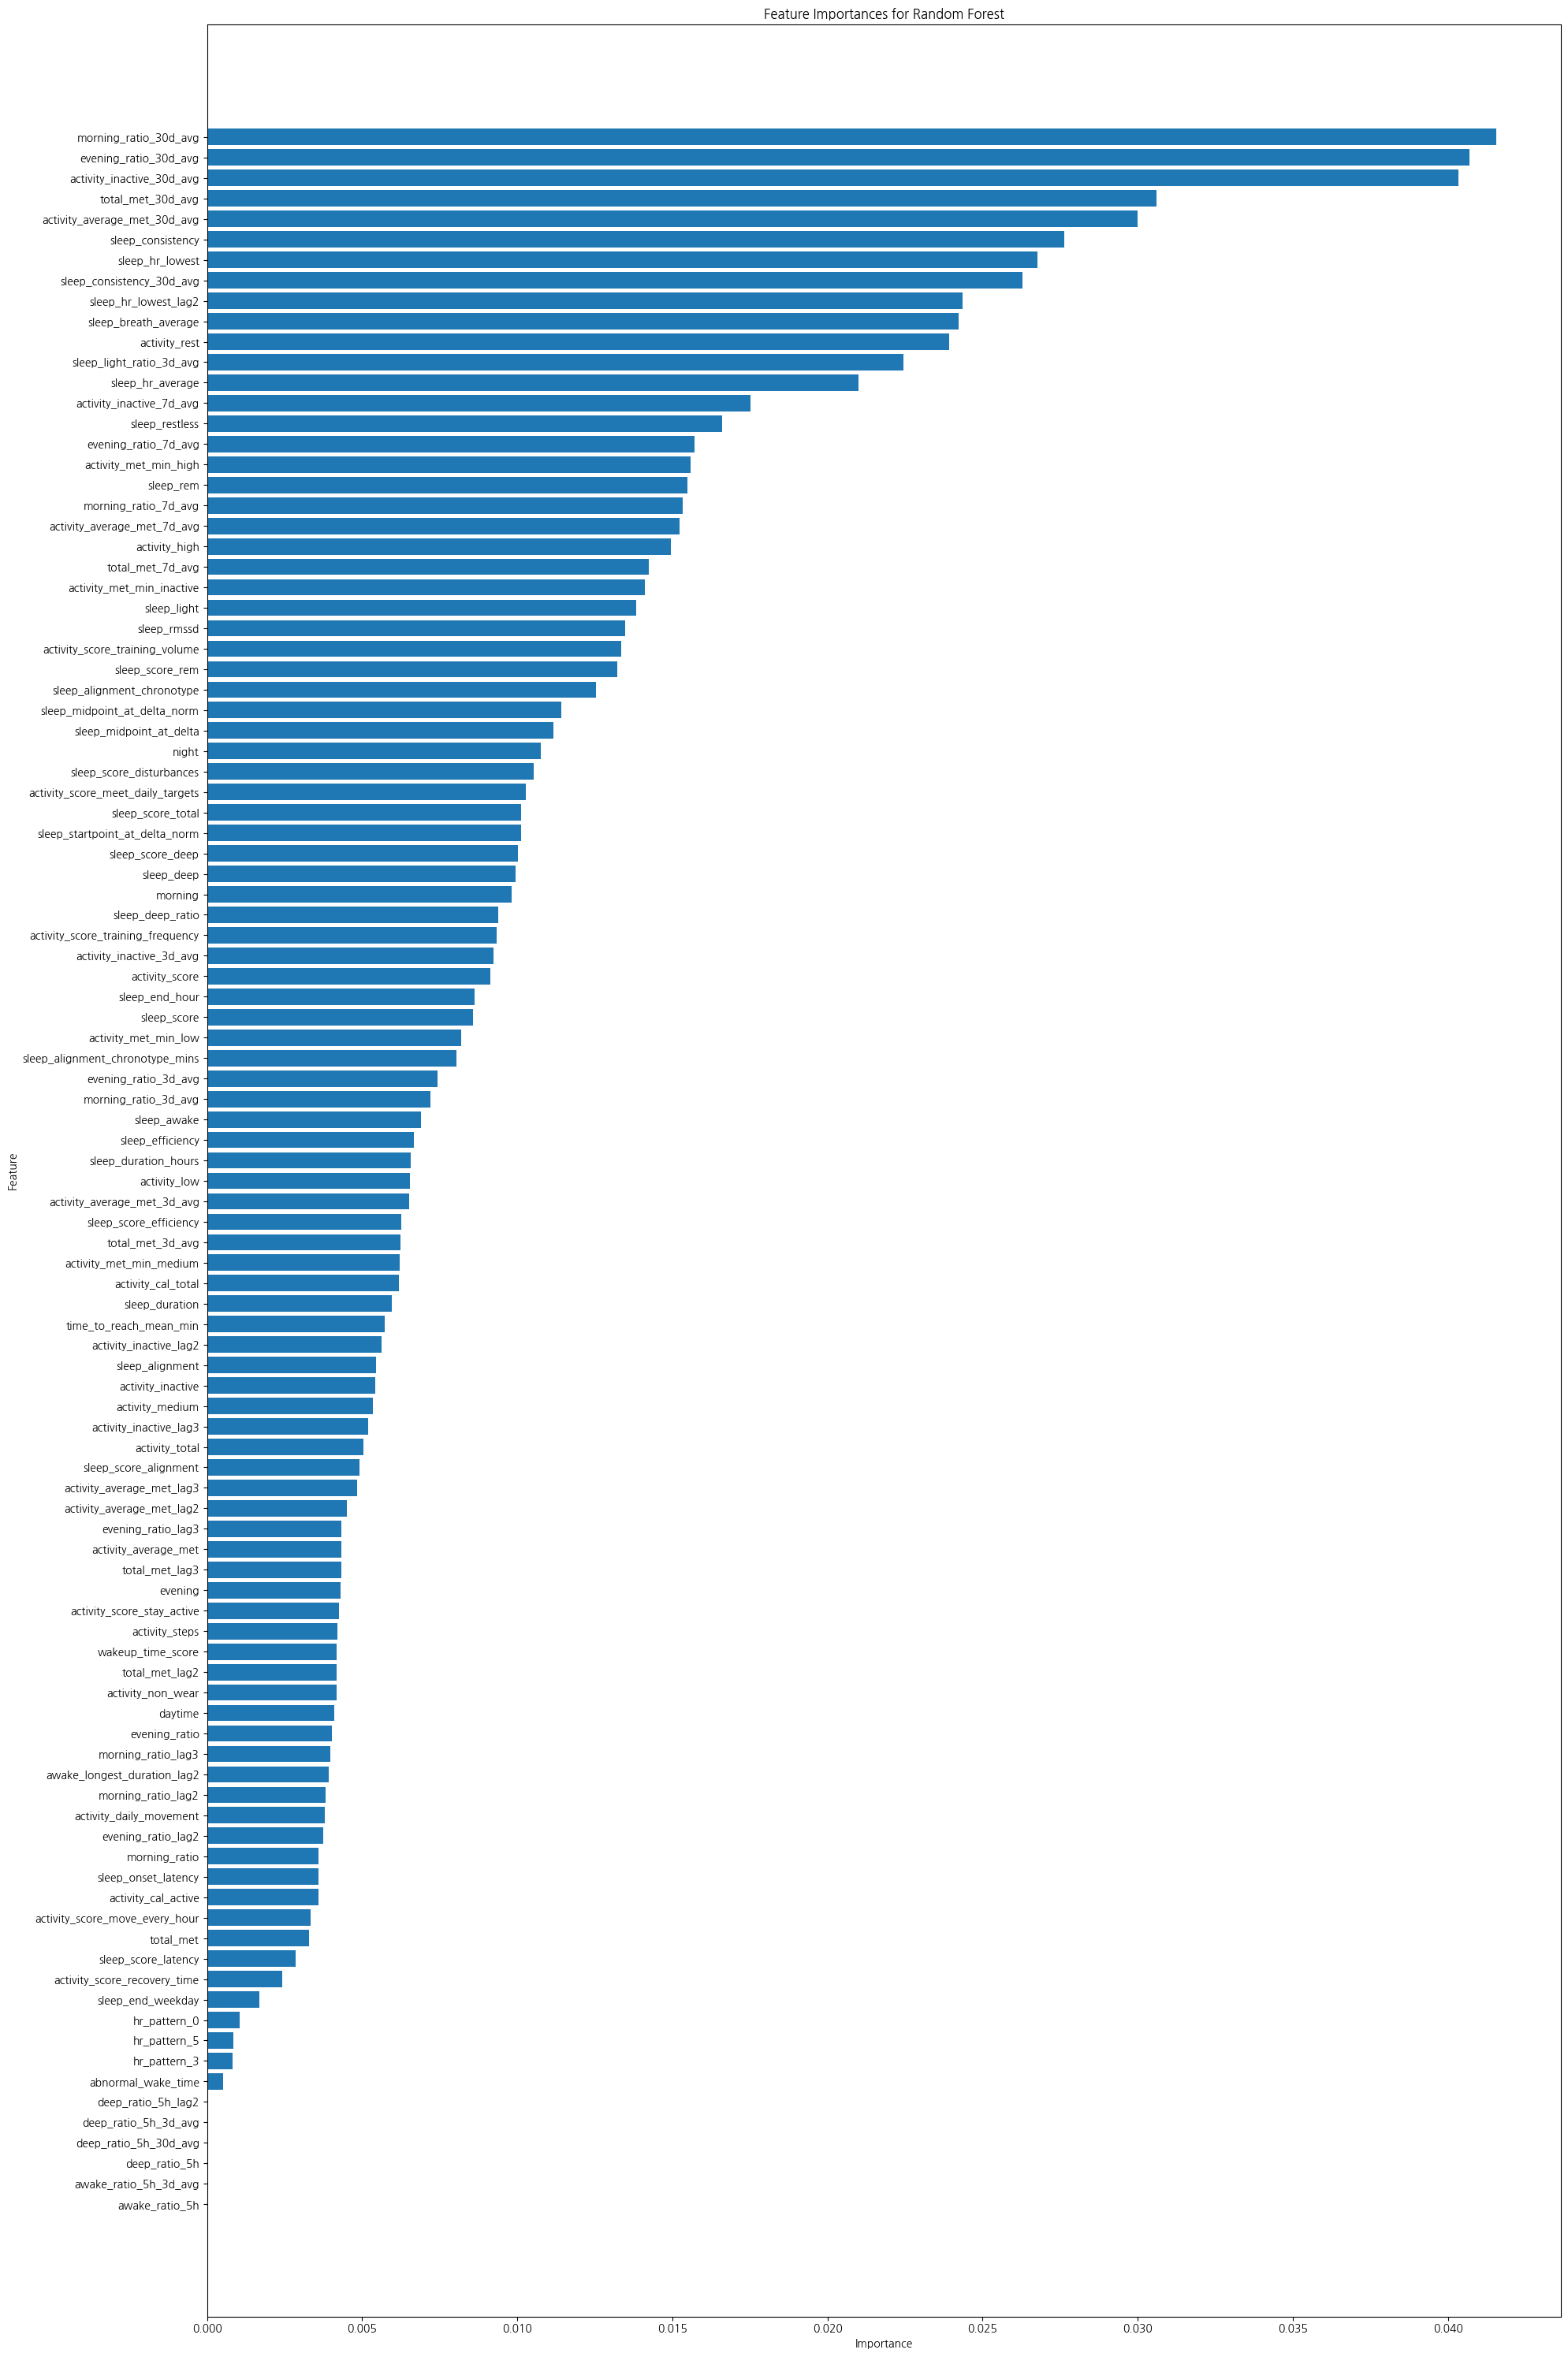

Low importance features for Random Forest:
                              Feature  Importance
67                         sleep_deep    0.009951
52                            morning    0.009813
68                   sleep_deep_ratio    0.009392
30  activity_score_training_frequency    0.009335
13           activity_inactive_3d_avg    0.009225
..                                ...         ...
40               deep_ratio_5h_3d_avg    0.000000
39              deep_ratio_5h_30d_avg    0.000000
38                      deep_ratio_5h    0.000000
36              awake_ratio_5h_3d_avg    0.000000
35                     awake_ratio_5h    0.000000

[66 rows x 2 columns]


In [169]:
low_importances = []

for name, model in models_.items():
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
        feature_names = merged_df.drop(["EMAIL", "label"], axis=1).columns
        importance_df = pd.DataFrame(
            {"Feature": feature_names, "Importance": feature_importances}
        )
        importance_df = importance_df.sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(20, 30))  # 그래프 크기 조정
        plt.barh(importance_df["Feature"], importance_df["Importance"])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title(f"Feature Importances for {name}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        # 피처 중요도가 낮은 피처 확인
        low_importance_features = importance_df[importance_df["Importance"] < 0.01]
        low_importances.append(low_importance_features)
        print(f"Low importance features for {name}:")
        print(low_importance_features)

In [172]:
low_importances[0]["Feature"].values[-30:]

array(['total_met_lag3', 'activity_medium', 'total_met_lag2',
       'evening_ratio_lag3', 'activity_inactive_3d_avg', 'activity_score',
       'evening_ratio_7d_avg', 'activity_inactive_lag3',
       'morning_ratio_lag3', 'activity_inactive_lag2', 'morning_ratio',
       'evening_ratio_lag2', 'evening_ratio', 'morning_ratio_3d_avg',
       'sleep_score_latency', 'total_met', 'abnormal_wake_time',
       'sleep_alignment_chronotype', 'morning_ratio_lag2',
       'activity_average_met', 'deep_ratio_5h_lag2',
       'deep_ratio_5h_3d_avg', 'deep_ratio_5h_30d_avg', 'deep_ratio_5h',
       'awake_ratio_5h_3d_avg', 'awake_ratio_5h',
       'activity_score_recovery_time', 'activity_inactive',
       'activity_cal_active', 'hr_pattern_5'], dtype=object)

# 모델 저장

In [171]:
with open("case5_model", "wb") as f:
    pickle.dump(model_, f)